## Librerias y primer vistazo a los datos

In [142]:
# Librerias generales
import pandas as pd
import numpy as np
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
from collections import Counter


# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios (solo la primera vez), despues dejamos comentado 
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# spaCy
#   python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

# Stopwords en inglés
stop_words = set(stopwords.words('english'))



### Vistazo general al dataframe

In [143]:
data = pd.read_csv('dataset\df_200k.csv')
data.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   id      200000 non-null  int64 
 2   date    200000 non-null  object
 3   query   200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [145]:
data.describe()

,target,id
count,200000.0,2.000000e+05
mean,0.0,1.772565e+09
std,0.0,1.520760e+08
min,0.0,1.467810e+09
25%,0.0,1.678338e+09
50%,0.0,1.793821e+09
75%,0.0,1.883596e+09
max,0.0,1.971571e+09


In [146]:
data.isnull().sum()

target    0
id        0
date      0
query     0
user      0
text      0
dtype: int64

In [147]:
data_clean = data[["text"]]
data_clean.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


## 1. Análisis exploratorio y preprocesamiento

### Análisis estadístico del corpus 

In [148]:
# Tokenización y limpieza básica (quita URLs, menciones, puntuación básica) 
# para el análisis inicial
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)        # URLs
    text = re.sub(r'@\w+', ' ', text)           # menciones
    text = re.sub(r'#', ' ', text)              # quitar # pero mantener la palabra

    # conservar letras y números (incluye acentos)
    # quitar acentos 
    text = re.sub(r'[^0-9a-záéíóúüñ\s]', ' ', text, flags=re.IGNORECASE)
    tokens = re.findall(r'\w+', text, flags=re.UNICODE)
    return tokens

In [149]:
# Construir distribución de frecuencias de tokens
freq = Counter()
total_tokens = 0
for doc in data_clean['text'].astype(str):
    toks = clean_and_tokenize(doc)
    freq.update(toks)
    total_tokens += len(toks)

vocab = len(freq)
print(f"Tokens totales: {total_tokens:,}")
print(f"Vocabulario (tipos): {vocab:,}")


Tokens totales: 2,736,879
Vocabulario (tipos): 75,418


In [150]:
# DataFrame-like structures para análisis
words, counts = zip(*freq.most_common())
ranks = np.arange(1, len(counts) + 1)
counts_arr = np.array(counts)


### Grafico Ley de Zipf

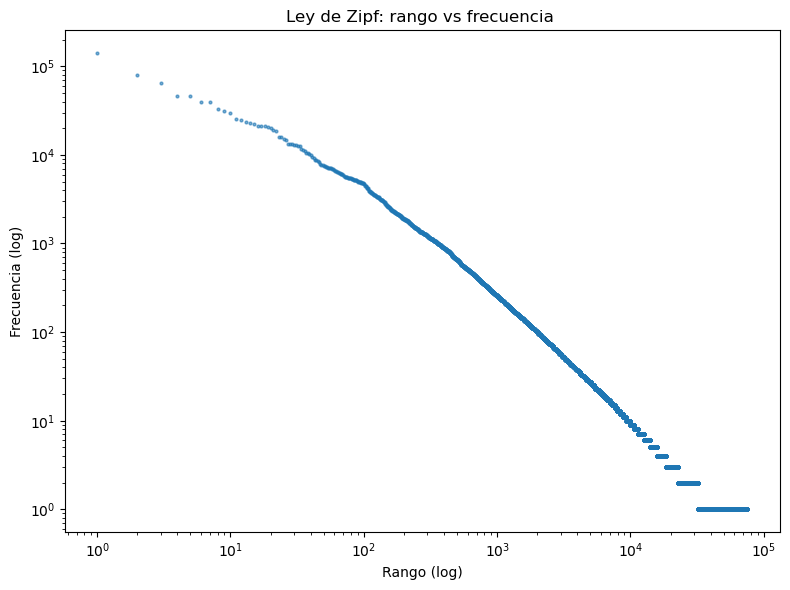

In [151]:
# Ley de Zipf: gráfico rango vs frecuencia (log-log) y ajuste lineal en log-log
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Ley de Zipf: rango vs frecuencia ')
plt.tight_layout()
plt.show()


Ajuste log-log (primeros 2000): slope = -1.1871, intercept = 13.7391
Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)


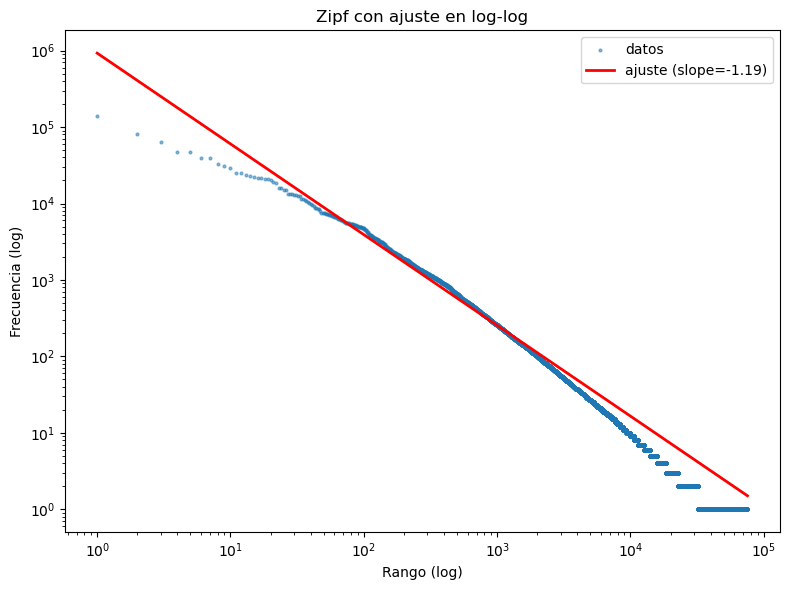

In [152]:
# Ajuste lineal en log-log para los primeros K ranks (p. ej. 1..2000)
K = min(2000, len(counts_arr))
log_r = np.log(ranks[:K])
log_f = np.log(counts_arr[:K])
slope, intercept = np.polyfit(log_r, log_f, 1)
print(f"Ajuste log-log (primeros {K}): slope = {slope:.4f}, intercept = {intercept:.4f}")
print("Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)")

# Dibujar la línea ajustada sobre el scatter 
pred_logf = intercept + slope * np.log(ranks[:])
pred_f = np.exp(pred_logf)
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.5, label='datos')
plt.plot(ranks[:], pred_f, color='red', lw=2, label=f'ajuste (slope={slope:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Zipf con ajuste en log-log')
plt.legend()
plt.tight_layout()
plt.show()

### Grafico distribuciones

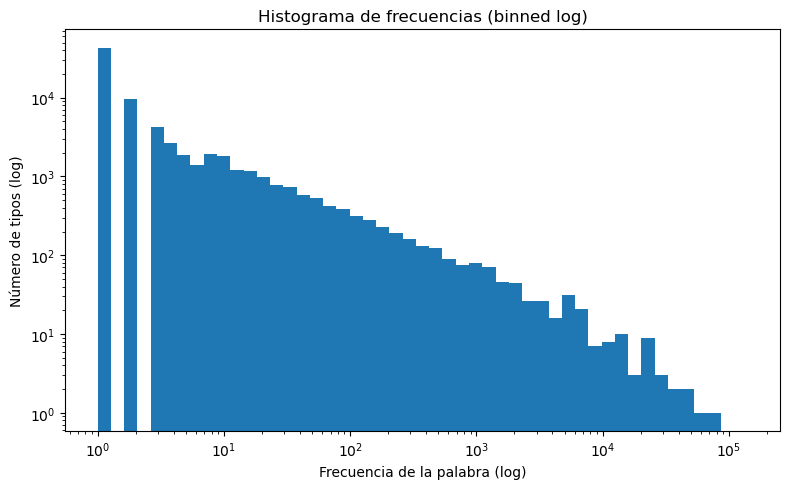

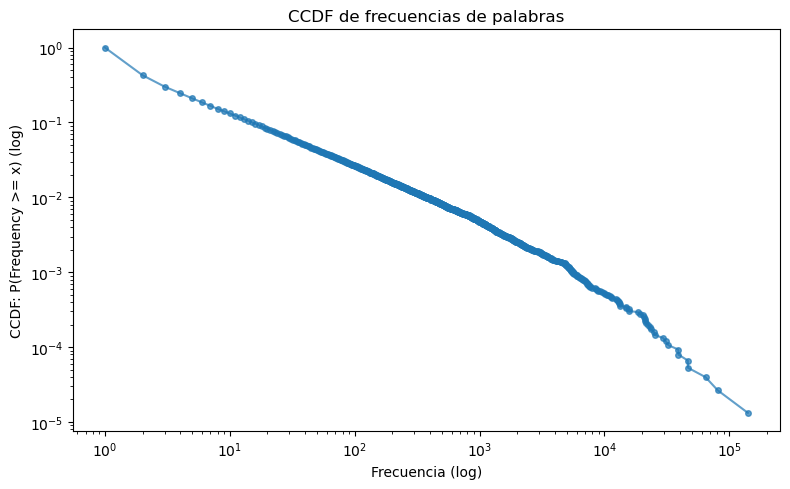

In [153]:
# Distribución de frecuencias: histograma (log-binned) y CCDF
# Histograma con ejes log
plt.figure(figsize=(8,5))
plt.hist(counts_arr, bins=np.logspace(np.log10(1), np.log10(counts_arr.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frecuencia de la palabra (log)')
plt.ylabel('Número de tipos (log)')
plt.title('Histograma de frecuencias (binned log)')
plt.tight_layout()
plt.show()

# CCDF: proporción de tipos con frecuencia >= x
sorted_counts = np.sort(counts_arr)
unique_vals, counts_of_vals = np.unique(sorted_counts, return_counts=True)
ccdf_vals = np.cumsum(counts_of_vals[::-1])[::-1] / vocab  # proporción de tipos >= val
plt.figure(figsize=(8,5))
plt.loglog(unique_vals, ccdf_vals, marker='o', ms=4, alpha=0.7)
plt.xlabel('Frecuencia (log)')
plt.ylabel('CCDF: P(Frequency >= x) (log)')
plt.title('CCDF de frecuencias de palabras')
plt.tight_layout()
plt.show()

## Pipeline de limpieza específico para tweets

In [154]:
# Limpieza de URLs y menciones
URL_PATTERN = r"http\S+|www\.\S+"
MENTION_PATTERN = r"@\w+"

# Sustituimos cualquier cosa no alfabética por espacio (dejamos espacios)
NON_ALPHA_PATTERN = r"[^a-z\s]"
EMOJI_PATTERN = r"[\U00010000-\U0010ffff]"  # rango Unicode emojis y pictos

def preprocess_review(text: str, nlp, stop_words) -> list:
    """
    Limpieza específica para reseñas EN:
      1) lower + expansión de contracciones (don't->do not)
      2) quita URLs, menciones y caracteres no alfabéticos
      3) normaliza números a <NUM> y emojis a <EMOJI>
      4) lematiza con spaCy (en)
      5) filtra stopwords y tokens cortos
    Devuelve: lista de tokens lematizados limpios
    """
    # 1) lower + contracciones
    text = text if isinstance(text, str) else str(text)
    text = text.lower()
    text = contractions.fix(text)  # "can't" -> "cannot"

    # 2) ruido típico de reseñas
    text = re.sub(URL_PATTERN, " ", text)
    text = re.sub(MENTION_PATTERN, " ", text)
    # Números y emojis se mapean a tags para no perder la señal semántica
    text = re.sub(r"\d+", " <NUM> ", text)
    text = re.sub(EMOJI_PATTERN, " <EMOJI> ", text)
    # El resto de signos no alfabéticos fuera
    text = re.sub(NON_ALPHA_PATTERN, " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # 3) Lematización spaCy
    #   Nota: spaCy tokeniza y da lemma por token; aquí ignoramos signos ya filtrados
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc]

    # 4) Filtrado final: stopwords + longitud mínima
    clean_lemmas = [w for w in lemmas if w not in stop_words and len(w) > 2]

    return clean_lemmas


In [ ]:
# Pasar de data_clean a df para mayor comodidad
df = data_clean.copy()

# Aplica el pipeline completo (tokens + lemas limpios)
df['lemmas'] = df['text'].astype(str).apply(lambda s: preprocess_review(s, nlp, stop_words))

# Texto limpio “join” (útil para TF-IDF, WordCloud, etc.)
df['clean_text'] = df['lemmas'].apply(lambda xs: " ".join(xs))

print(f" Procesadas {len(df)} reseñas. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'")
df.head(3)


 Procesadas 200000 reseñas. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'


,text,lemmas,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, get, david, carr, thir...",awww bummer shoulda get david carr third day
1,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texte, might, cry, r...",upset update facebook texte might cry result s...
2,@Kenichan I dived many times for the ball. Man...,"[dive, many, time, ball, manage, save, rest, b...",dive many time ball manage save rest bound


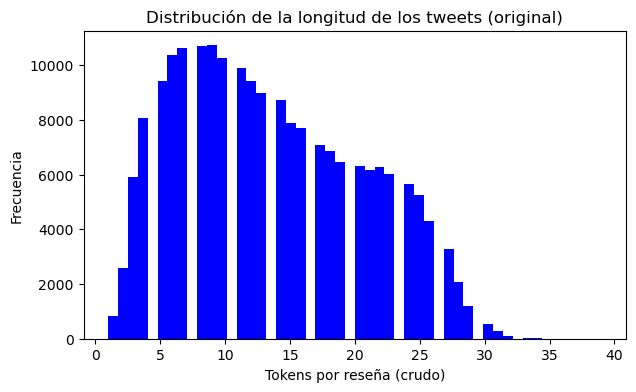

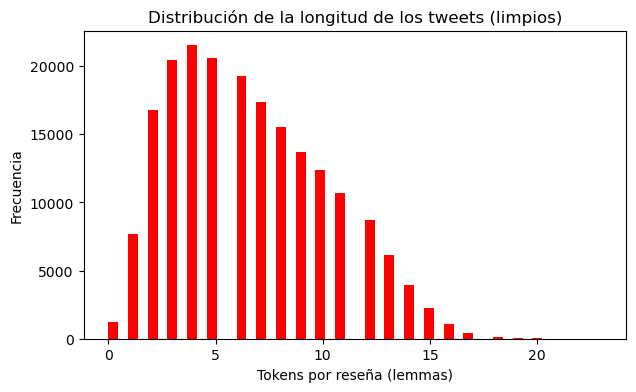

 Media longitud cruda: 13.58 | Media longitud limpia: 6.60


In [ ]:
# Longitud cruda por reseña (número de palabras)
len_raw = df['text'].astype(str).apply(lambda s: len(s.split()))

# Longitud tras limpieza (número de lemas por reseña)
len_clean = df['lemmas'].apply(len)

# Histograma antes y después de limpieza
plt.figure(figsize=(7,4))
plt.hist(len_raw, bins=50, color='blue')
plt.title("Distribución de la longitud de los tweets (original)")
plt.xlabel("Tokens por reseña (crudo)")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(len_clean, bins=50, color='red')
plt.title("Distribución de la longitud de los tweets (limpios)")
plt.xlabel("Tokens por reseña (lemmas)")
plt.ylabel("Frecuencia")
plt.show()

print(f" Media longitud cruda: {len_raw.mean():.2f} | Media longitud limpia: {len_clean.mean():.2f}")


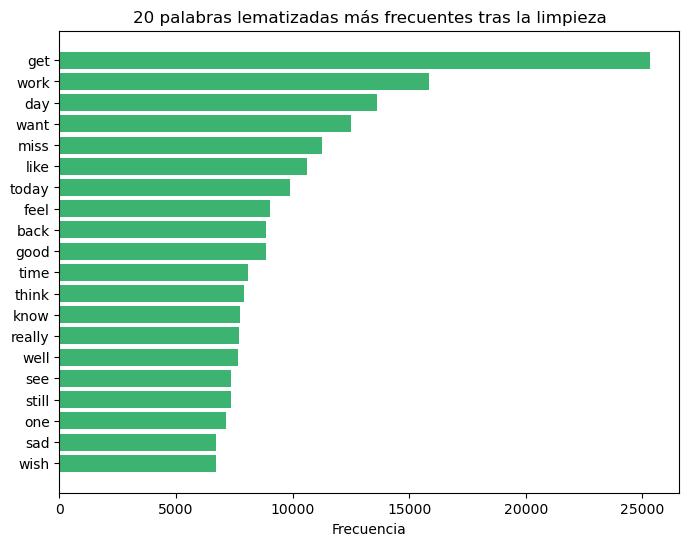

In [157]:
# Aplana la lista de lemas
flat_lemmas = [w for toks in df['lemmas'] for w in toks]
top20 = Counter(flat_lemmas).most_common(20)

# Mostrar el top-20
words, freqs = zip(*top20)
plt.figure(figsize=(8,6))
plt.barh(words, freqs, color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("20 palabras lematizadas más frecuentes tras la limpieza")
plt.xlabel("Frecuencia")
plt.show()



## Identificación de patrones sintácticos relevantes

C:\Users\javie\AppData\Local\Temp\ipykernel_26872\2045220747.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')


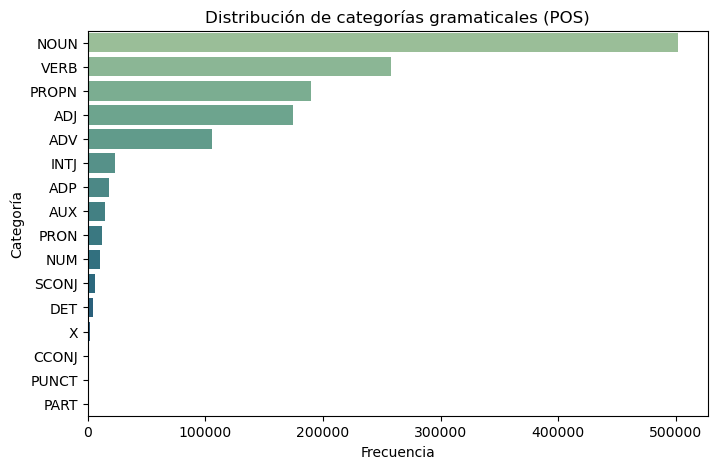

C:\Users\javie\AppData\Local\Temp\ipykernel_26872\2045220747.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')


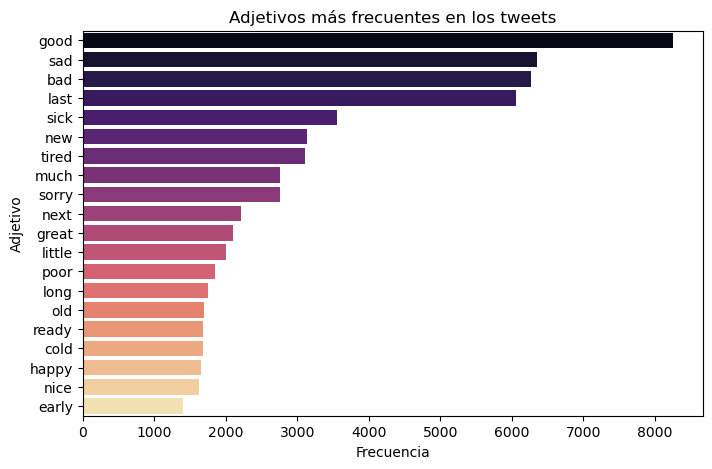

,Adjetivo,Frecuencia
0,good,8253
1,sad,6350
2,bad,6273
3,last,6054
4,sick,3554
5,new,3136
6,tired,3110
7,much,2763
8,sorry,2763
9,next,2216


In [158]:
# Tomamos una muestra del corpus para análisis sintáctico
sample_texts = df['clean_text'].tolist()

# Analizamos con spaCy
docs = list(nlp.pipe(sample_texts, disable=['ner']))

# 1️ Distribución de etiquetas gramaticales (POS)
pos_counts = Counter([token.pos_ for doc in docs for token in doc])
pos_df = pd.DataFrame(pos_counts.most_common(), columns=['POS', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')
plt.title("Distribución de categorías gramaticales (POS)")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

# 2️ Adjetivos más frecuentes (indicadores de opinión)
adj_counts = Counter([token.lemma_ for doc in docs for token in doc if token.pos_ == 'ADJ'])
adj_df = pd.DataFrame(adj_counts.most_common(20), columns=['Adjetivo', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')
plt.title("Adjetivos más frecuentes en los tweets")
plt.xlabel("Frecuencia")
plt.ylabel("Adjetivo")
plt.show()

display(adj_df.head(10))
